# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [5]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['excl_count'] = toxic_data['comment_text'].str.count("!")



    X_quant_features = toxic_data[["word_count", "punc_count",  "excl_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [6]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/toxiccomments_train.csv', my_random_seed=700)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [7]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12906, 'Neg': 114750, 'TP': 6584, 'TN': 56231, 'FP': 58519, 'FN': 6322, 'Accuracy': 0.4920646111424453, 'Precision': 0.10113205228637698, 'Recall': 0.5101503176816984, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12885, 'TN': 114505, 'FP': 144, 'FN': 122, 'Accuracy': 0.997916274989033, 'Precision': 0.9889477319825005, 'Recall': 0.9906204351503037, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12951, 'TN': 114598, 'FP': 51, 'FN': 56, 'Accuracy': 0.9991618098640095, 'Precision': 0.9960775265343793, 'Recall': 0.9956946259706312, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12749, 'TN': 103299, 'FP': 11350, 'FN': 258, 'Accuracy': 0.9090681205740427, 'Precision': 0.5290261006680775, 'Recall': 0.9801645267932652, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12877, 'TN': 114506, 'FP': 143, 'FN': 130, 'Accuracy': 0.9978614401203234, 'Precision': 0.9890168970814132, 'Recall': 0.9900053817175367, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [8]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12906, 'Neg': 114750, 'TP': 12868, 'TN': 99949, 'FP': 14801, 'FN': 38, 'Accuracy': 0.8837579118881995, 'Precision': 0.465069211030395, 'Recall': 0.9970556330388967, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=100, random_state=0)

rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/robincoenen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12906, 'Neg': 114750, 'TP': 5940, 'TN': 114749, 'FP': 1, 'FN': 6966, 'Accuracy': 0.9454236385285455, 'Precision': 0.9998316781686585, 'Recall': 0.4602510460251046, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

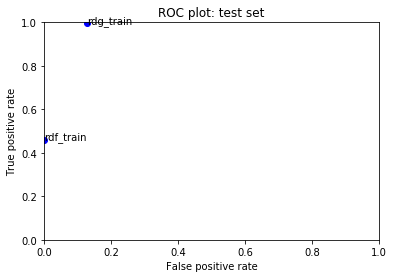

In [11]:
fits = [rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [15]:
rdg_predictions = rdg.predict(X_train)

In [17]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
30
Please don't add indiscriminately fuill tables of contents of journals to wikipedia. Wikipedia need information and references to verify the information in wikipedia articles. wikipedia is an encyclopedia, not a catalog of everything what was ever published on the subject everywhere.
* * * * * * * * * 
202
"

 Operation Condor is also named a Dirty War.  

Can this be mentioned in the introduction of the article?

The Dirty War in Argentina is just one dirty war of many. Operation Condor was a multinational dirty war, and operated in many nations, and used many similar methods. See this August 2001 English article from Le Monde Diplomatique: ""Latin America: the 30 years’ dirty war"". "
* * * * * * * * * 
257
(shakes head) u just think every1s evil dont u? haha jk <3
* * * * * * * * * 
274
Was this a live or automated response?
* * * * * * * * * 
1399
"

May Allah (swt) either give you punishment or hidiyaat for spreading falsehood and keeping other Musl

10902
"I would like to mention that you made the rather blatant sexual and violent yourself so if you want to call the police for sending ""sexually harassing messages"" to yourself, be my guest. My original message (which was, admittedly, not very civil itself and I do apologize) was quite different. It can also be grounds for a block yourself. (I'm also rather amused by this formerly congratulatory comment being removed.)   

"
* * * * * * * * * 
11322
"

 Dream theater template 

I've been a DT fan since images and words. I know a lot about them. Im wondering how come ""Six degrees of inner turbulence"" and ""A change of season"" aren't on the template. I added them and someone deleted them. Im just wondering, those 2 songs ARE infact Suites.  "
* * * * * * * * * 
11556
"

 RfC 

I find it kind of amusing that you simultaneously note an under-representation of women on ArbCom while calling Risker a ""he"". )   "
* * * * * * * * * 
11831
"

Optional question
I've asked a question on 

21701
"
I want an unblock and a RFC. I will not tolerate tag-team harrasmment by the same small RW group who just drove Seven Of Diamond off Wiki, and harras and drive out any leftist with organized team tactics. Dheyward Wikistalked me. Here is what I last wrote but couldn't post on ANI
Neither of you talk to the troll edit Dheyward made, then when I asked to talk to him about it, he deleted my question on his talk page as 'trolling'. His edit was 100% POINT and trolling and hurt the article, not helped it. He knew the correct info, but would have rather made a POINT troll edit instead! That is WP abuse and an attempe to bait me. Δbutler• "
* * * * * * * * * 
21991
See the attached document from the FAA which uses it. A properly sourced usage is preferable over an unsourced conjectural usage.
* * * * * * * * * 
22066
Thanks for calling me a zombie 

Mind if I eat your brain? Just because I don't edit much doesn't make me a zombie account.  (talk|contrib)
* * * * * * * * * 
22253
"

Di

32878
I reverted the edits to what people NEED to know, now what some idiot in Toronto THINKS people should know.. CHEERS!
* * * * * * * * * 
33156
hey I got an idea how about you just relax and listen to tupac it doesnt matter how many records he sold he is THE GREATEST rapper to ever put it down.
* * * * * * * * * 
33385
" February 2010 (UTC)
I'm another someone else - and a part of the gay community - and I have an issue with it as well.  I totally agree that the use of ""homosexual"" is clinical and except for instances where clinical terms in this article are appropriate, ""gay"" should be used instead.    22:08, 22"
* * * * * * * * * 
33420
"

Learn some english, get into the US frontiers, the Attorney General will take care of you.
If you continue to edit my comments i will edit your page.
I have hundreds of compusers ready to help in this, the most powerful country and at this, the most wonderful state of the Union.
I wrote in my comment ""god bless America"" and you deleted it

38886
I have nothing to do with this sock pupperty thing, I had apologized and I dont know what else to do.  If you believe that someone else is me, then whoever is accusing me of this should prove it.
* * * * * * * * * 
38964
"

A pat on the head
KC, you are one of the most dedicated Wikipedians I know and I'm madly in love with you. I'd give you a Barnstar but in the end you'd just chew it up and bury it. Instead, let me offer this metaphorical pat on the head: ""That'll do Pup, that'll do.""  see you around   )  Tropics "
* * * * * * * * * 
39151
Yes, there is a Middle School, now in the second year, in the remodeled (formerly) Industrial Arts building.
* * * * * * * * * 
39335
I am not vandal 

I am lost and alone and looking for soup.
* * * * * * * * * 
39368
I am refering to this https://en.wikipedia.org/wiki/File:Metric_UK_road_sign.tif
* * * * * * * * * 
40045
Because that person watches WWE Smackdown and says thats what is was called when he came out last Friday
* * * * * * * 

49056
The edibility ref in the pencil article has the context of pencil lead being graphite and not toxic lead. (I removed the senseless heavily bit). On the graphite page the addition of edibility with no context is meaningless. It has no nutritional value - what is the point?
* * * * * * * * * 
49284
Oops, you are right.
* * * * * * * * * 
49354
Fly away and grow up from your classic bullying, threats and petulant silencing. We're all praying for you to, but in the hiatus we're laughing at you.
* * * * * * * * * 
49380
children, nobody is better than anybody else – we’re all equal
* * * * * * * * * 
49412
Hey WTF mate? 
Listen that page was for ashleigh spittelers birthday when you deleted it!!!! Whats wrong with it
* * * * * * * * * 
49644
.  (Ah, did I hurt you?)  Just call this a response to your liberal tirade
* * * * * * * * * 
49699
"== Talk: Diary of a Wimpy Kid; Rodrick Rules ==

Nobody or nothing is perfect
- Anonymous

Hi. I created this article. I think ""cheesy"" is an op

53766
You can thank DreamGuy for being outed. You can't block me.
* * * * * * * * * 
53809
"

 I grow tired of protecting articles from bully users. 

AMIB and this other guy, the one word I can associate with them is ""bully"". They think that they can get away with telling people that their opinions hold no weight in this matter and delete an article. Both of the users are trying to make up reasons for the article to be deleted. The first was that it was of low quality and beyond repair, the second was (and this is the worst) is that a result of keep can result in a redirect, on the basis that redirect votes add to keep, not delete and the third one is that it is unsourcable and should be deleted - unlike the majority of articles which have no sources. There is no logic to this. They didn't create  for fun. I'm not in the mood to be polite with people who aren't interested in acknowledging any other view but their own. -  (talk) "
* * * * * * * * * 
53921
"
What killed Timothy Treadw

58923
i don't care to do what is right you CIA scumbag 

i don't care to do what is right you CIA scumbag
* * * * * * * * * 
58958
T.I. Trouble Man: Heavy Is the Head
* * * * * * * * * 
59036
Probably not, as there aren't any real details available about the company. Microsoft never gave any of their companies a background, as it wasn't necessary for game usage.
* * * * * * * * * 
59152
Queer Wikipedians
You are creating an article in the main namespace, not a category (:Category:Queer Wikipedians) or an article in the meta namespace like Wikipedia:Queer Wikipedians, where I already moved your text.
* * * * * * * * * 
59634
Note to Bertil Videt=
Bertil
I started to think that there is something seriosly wrong with your ability to interpret the factual information. With this going in your virtual world, your master's degree will be a fake one.
* * * * * * * * * 
59642
Hahaha 

Mr range is far too vast. You canb't rangeblock me. And I'm never gonna stop. I'm also going to do some horribl

70289
REDIRECT Talk:Songfa Road Station
* * * * * * * * * 
70474
I agree with the Colonel and think he is a genius of unparalleled stature. Whatever happened to you, anyway? The world is growing stupid without your input.
* * * * * * * * * 
70752
And as an addition King Dubya's regime is a fascist one. His take over can be easily compared to Hitler's takeover of the German republic. They are amazingly similar in many ways.
* * * * * * * * * 
70865
What is your problem???? 

alternative rock??????????(like a placebo,radiohead,30stm)...
To the ignorant people who put this genre: Do you even know what Alternative Rock is??? How can you label HIM as Alternative Rock??? The latest album might have some elements of it, but HIM is NOT an Alternative Rock band... They have Gothic Rock elements, Metal elements, Glam Rock elements and much more...they are love metal
* * * * * * * * * 
71158
David Gerard, when you block everyone who has called anyone a troll, then you can block me for implying it

81092
Plot Hole
STOP MESSING AROUND WITH THE PLOT HOLE PART!!! IT DESERVES TO BE THERE!!! SO STOP ERASING IT!!!Tim, 6 January, 2006
* * * * * * * * * 
81107
THANK YOU SO MUCH!!
Thanks for showing me the Uncyclopedia thingy, serously.  You have shown me a place to get vandalism out of my system effectively.  It also made me laugh.  Thanks again!  user:Skypoper
* * * * * * * * * 
81173
"A lot of people still pronounce it as ""Conway"" however. "
* * * * * * * * * 
81229
And how does that apply to the article? This is just a discussion page - were you neutral on my Jewish contribution that you reverted? 98.94.163.97
* * * * * * * * * 
81273
Please stop. If you continue to vandalize pages, as you did to African slave trade, you will be blocked from editing Wikipedia.
* * * * * * * * * 
81346
"

This is the website, http://en.wikipedia.org/wiki/History_of_the_term_Vlach 

it clearly states that it is ""(pejorative)"" = racist
thus, i need evidence that Serbs and Vlah's are the same as you c

86598
I think he was just the vocalist for The Brogues but didn't play guitar in that band.96.232.53.143
* * * * * * * * * 
86704
"

 deanostrodamus 

don't try to threaten me just because you can't fit through the doors of your favorite comic book store, even if you did delete me i will find a way back on to continue being what you whould call ""disruptive"". honestly if you have some problem with me or if wikipedia is the only place you feel your life has a point please just come out and say it instead of wasting my short free time. i will not make fun of you or any of your yuppie ideals because in a way i pity you and i know you'll only go and get your D&D; buddies to try to increase your meddle, in short ""How can I kill that which has no life""."
* * * * * * * * * 
87004
Just a few paragraphs above yours, Steel busted me for accusing Wildhartlivie of sockpuppetry.  Now you're accusing me of it.  You don't want to get banned for 24 hours, do you?  This paragraph that I'm writing no

91804
Move
Move to Penn State sex abuse scandal per NBC Nightly News (see here? This not just about Jerry Sandusky's alleged crimes, but the coverup scandal.
* * * * * * * * * 
92165
I am aware you have rudely decided not to create a wikipedia account, thus making it needlessly difficult for people to communicate with you and track your actions in general. I do not see why this is a reason for me to make it even harder by not linking your posts to your current IP. Algebraist
* * * * * * * * * 
92178
" 
The article meets notability guidelines, which I will explain to him shortly. If there's no open period for discussion, then the judgment of notability is by fiat rather than an open process. It's elitist, and it drives away contributors in favor of anti-social nerds. And you meant ""too fast."" I edited it for you. ~~~~
"
* * * * * * * * * 
92237
If you haven't asked already, go ahead. Have fun today!
* * * * * * * * * 
92310
You think this is mop and bucket? You should see the lock dow

97002
Abdullah Öcalan 

Hi, could you tell me why you reverted my edit on Abdullah Öcalan. Btw its me,i forgot to sign in.
* * * * * * * * * 
97043
uh 

next time you leave a comment on my page, make sure it makes sense hun and not some BS comment.  i just undid an edit. chill out k?
* * * * * * * * * 
97366
Silly Steve Nash‎ edits
Stop it.
* * * * * * * * * 
97446
Alternatively, tell me how can I get rid of this user.
* * * * * * * * * 
97548
Ya I'll give you a source - everyone that knows her.
* * * * * * * * * 
97628
Actually, the whole fact that it's an encyclopedia on the internet that anyone can edit (therefore has questionable reliability) gives Wikipedia a bad name. But enough. When I said 'boring' I was using it as a derogatory term in general. Although he is boring, I was attacking him because I don't buy his theories because I think he presents them in an unintelligent light. I didn't take it very seriously because I don't think it was written seriously (although he was thor

102302
BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE
* * * * * * * * * 
102346
"

Modesty

""I am a 13-year old smart male"". Come on mate, no one likes arrogance."
* * * * * * * * * 
102440
I'd rather spend $70 a year than have to be forced your lines of BS, anyday.
* * * * * * * * * 
102490
The painting can be the lede image there is nothing wrong, people expect to see a Rothko painting when t

107665
Stop harassing me or I WILL complain 
User keegscee started attacking me out of nowhere, not the other way around. That should be easy to verify. If you don't leave me alone both of you, I will complain and get both you blocked. 93.161.107.169
* * * * * * * * * 
108064
Somebody examine this goof's censorship of Kleargear shall we?

What is his (paid) motivation after ALL these many months?
* * * * * * * * * 
108304
"
Thank you for your contribution and please excuse the delay in my acknowledgement. — O'Dea  "
* * * * * * * * * 
108391
Grow up little man, its rather pathetic you sit here trying to use Wikipedia for political attacks.
* * * * * * * * * 
108466
Your very smart arent you;), well guess what? ye may have got rid of me again but im already back;), ye need to realize ye can report me all ye like but I will keep coming back! and there is nothing ye can do to stop me! 86.46.249.176
* * * * * * * * * 
108482
my question is: why this guy has not yet banned? Other old vandal

113279
And so, an advise becomes threat. This looks like a job for  (please deposit payment in tuna).
* * * * * * * * * 
113680
"

It would appear to me that most of the administrators I have been dealing with are self righteous and so impressed by the fact that they are ""Almighty Administrators"" that they have entirely no sense of humor whatsoever.  You talk really tuff as though you are really going show me a thing or two.  I think you just enjoy the feeling of power that you have over my life.  With one click of the keyboard you can destroy my article for good.  I guess you think I'm supposed to be devastated or something.  Suppose I am banned from Wikipedia once more for speaking freely?  It's really not going change the Earth's rotation rate or anything.  I guess if you don't have a life and are condemned to sitting around and watching ""encyclopedia"" entries all day without getting paid for it then you might turn out to be humorless and irritable.  How can I be accused of vand

118379
You have inconsistency in your work. Cat:Villages and municipalities in the Trenčín Region but Cat:Villages and municipalities of the Nitra Region. You better choose one style and fix that. I can then delete unused categories. -
* * * * * * * * * 
118388
Question? do you think of yourself as a troll? if not, could you explain why nearly all of your edits to this (and related) talk pages are trolling?
* * * * * * * * * 
118573
"

""A 9mm gun is normally used for grinding out. It can also be useful in protecting lines.""

What in the world does this mean? This is an encyclopedia, intended to inform readers who are not experts in a given field. Please define grinding out and protecting lines if you think they are germane to the definition of 9mm caliber. Thank you. - "
* * * * * * * * * 
118733
How could Muhammad have been the author if he was illiterate?
* * * * * * * * * 
118993
"

Admin abuse of other editors combined with great stupidity, all in a context of extensive bullying 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1578, 'TN': 14826, 'FP': 13871, 'FN': 1640, 'Accuracy': 0.5139902866990443, 'Precision': 0.10214253349731374, 'Recall': 0.490366687383468, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2076, 'TN': 27106, 'FP': 1591, 'FN': 1142, 'Accuracy': 0.9143662854457152, 'Precision': 0.5661303517862013, 'Recall': 0.6451211932877564, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2022, 'TN': 27245, 'FP': 1452, 'FN': 1196, 'Accuracy': 0.9170296099013003, 'Precision': 0.5820379965457686, 'Recall': 0.6283405842137973, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2088, 'TN': 23600, 'FP': 5097, 'FN': 1130, 'Accuracy': 0.804887983706721, 'Precision': 0.2906054279749478, 'Recall': 0.6488502175264139, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2070, 'TN': 27106, 'FP': 1591, 'FN': 1148, 'Accuracy': 0.9141782860723797, 'Precision': 0.5654192843485386, 'Recall': 0.6432566811684276, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [29]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3319, 'Neg': 28596, 'TP': 3191, 'TN': 22697, 'FP': 5899, 'FN': 128, 'Accuracy': 0.8111546294845684, 'Precision': 0.35104510451045107, 'Recall': 0.9614341669177463, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [28]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3319, 'Neg': 28596, 'TP': 682, 'TN': 28577, 'FP': 19, 'FN': 2637, 'Accuracy': 0.9167789440701865, 'Precision': 0.9728958630527818, 'Recall': 0.20548357939138295, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

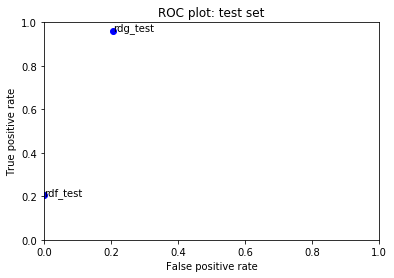

In [30]:
fits = [rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [31]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../data/toxiccomments_test.csv', my_random_seed=700, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  excl_count
0          72          10           0
1          13           1           0
2          16           0           0
3          38           3           0
4           7           1           0


---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [32]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.4159397769710898


In [33]:
raw_data.head()

,id,comment_text,word_count,punc_count,excl_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0


In [34]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [35]:
my_submission.shape

(153164, 2)

In [38]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission_d23.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation